This notebook focuses on analysing the Seattle AirBnB dataset available from [Kaggle](https://www.kaggle.com/airbnb/seattle/data). This notebook was done as a project for the Data Scientist Nanodegree program on Udacity.

# Package import ad paths setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import missingno
import seaborn as sns
from functools import reduce

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
import shap

In [2]:
%matplotlib inline

In [3]:
DATA_FOLDER = Path('../data')

In [4]:
!ls $DATA_FOLDER

calendar.csv  reviews.csv  X_train.pkl	y_train.pkl
listings.csv  X_test.pkl   y_test.pkl


In [5]:
calendar = pd.read_csv(DATA_FOLDER / 'calendar.csv')
listings = pd.read_csv(DATA_FOLDER / 'listings.csv')
reviews = pd.read_csv(DATA_FOLDER / 'reviews.csv')

In [6]:
pd.set_option('display.max_rows', None)

# Data quality

In this first section we will look into the quality of the data. Specifically we will look at missing values in the data. I like to use the package [missingno](https://github.com/ResidentMario/missingno), which gives a good overview of columns and where there are missing values.

## Calendar data

In [7]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [8]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


From the info above, we have some columns that need cleaning and type conversion. The date column needs to be converted to a datetime type and the price column needs to be cleaned and converted into a float type.

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


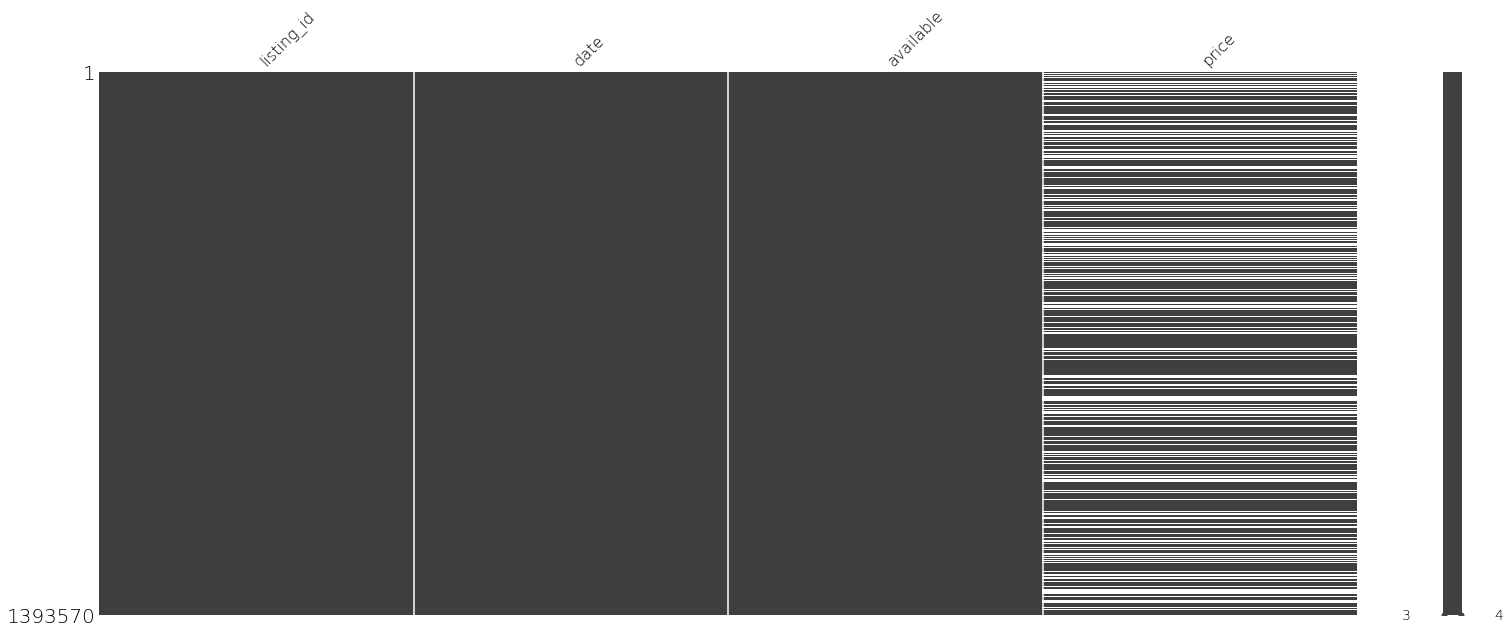

In [9]:
missingno.matrix(calendar);

This data shows what prices listings have had at a given time. Also it shows if the listing has been rented out or not.

Apparent from above is that the price column often has null values. Seing as the data lists prices and availability given a certain date, it is possible that this is a natural thing, since listings will be shown without prices, whenever they are rented out to visitors. We can investigate this by filtering all rows where `available == 'f'` and counting number of unique values

In [10]:
calendar[calendar['available'] == 'f']['price'].value_counts()

Series([], Name: price, dtype: int64)

Indeed for all rows where the listing is not available, price will be a NaN. We can also investigate if there are any rows with available listings where the price is NaN

In [11]:
calendar_nans = calendar[calendar.isna().any(axis=1)]

In [12]:
len(calendar_nans[calendar_nans['available'] == 't'])

0

This shows that the data is clean and we have a price for every row where a listing is available.

In [13]:
print(f'Number of rows in calendar data: {len(calendar)}')

Number of rows in calendar data: 1393570


### Cleaning

In [14]:
def clean_calendar(calendar):
    calendar_clean = calendar.copy()
    
    # Converting the date to a pandas datetime type
    calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])
    
    # Removing calendar entries from when the properties are rented out
    #calendar_clean = calendar_clean[calendar_clean['available'] == 't']
    
    # Converting price to a float value
    calendar_clean['cleaned_price'] = calendar_clean['price'].str.replace('[$,]','').astype('float')
    
    return calendar_clean

In [15]:
calendar_clean = clean_calendar(calendar)

## Listings data

In [16]:
# Allow printing of more rows, so we can see content of all columns in listings dataframe.
pd.options.display.max_rows = len(listings.columns)

In [17]:
listings.sample(10).T

,1692,3127,460,1433,1134,3163,2314,1627,1967,184
id,5957039,9410302,2267088,6490091,244499,3215404,797358,6494181,7596934,380950
listing_url,https://www.airbnb.com/rooms/5957039,https://www.airbnb.com/rooms/9410302,https://www.airbnb.com/rooms/2267088,https://www.airbnb.com/rooms/6490091,https://www.airbnb.com/rooms/244499,https://www.airbnb.com/rooms/3215404,https://www.airbnb.com/rooms/797358,https://www.airbnb.com/rooms/6494181,https://www.airbnb.com/rooms/7596934,https://www.airbnb.com/rooms/380950
scrape_id,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432
last_scraped,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04
name,"Waterfront Views, Right Downtown!",1bdrm Ravenna/Greenlake/Udistrict,2 BDR GARDEN APT + PATIO/GRILL+PKG,Master Bedroom - Private bathroom,Incredible View Lake Union Condo!,Great Downtown View from Queen Anne,Cozy Old House Near City Center,"2BD, 1.5 Bath View Penthouse",PHINNEY BUNGALOW,Craftsman Charmer w/ Stunning Views
summary,"Downtown, cute, cozy studio with views of wate...","Great little apartment. Spacious Bedroom, comf...","COMFORTABLE QUIET 2- BDR/BATH + PATIO, ON RESI...",Luxurious single master bedroom in the heart o...,"We love our condo! It has a central location, ...",1BD apartment - amazing view of downtown Seatt...,Guest room with a comfy queen size bed and pri...,"Seattle Suites, LLC manages privately owned fu...",PRIVATE GUEST HOUSE SITUATED IN THE HEART OF P...,Charming Old World Seattle Craftsman Home with...
space,This apartment is right at the heart of downto...,"The space is clean, simple and open. A nice an...",•Two-Bedroom - quiet spacious bedrooms - king ...,NaN,Visit Seattle anytime of the year! Enjoy our m...,NaN,Hi and welcome to Seattle! My house is in a g...,Live like a Seattleite. In the heart of downt...,"GAS FIREPLACE, HARDWOOD FLOORS. KITCHEN INCLU...",Charming Old World Craftsman Home located conv...
description,"Downtown, cute, cozy studio with views of wate...","Great little apartment. Spacious Bedroom, comf...","COMFORTABLE QUIET 2- BDR/BATH + PATIO, ON RESI...",Luxurious single master bedroom in the heart o...,"We love our condo! It has a central location, ...",1BD apartment - amazing view of downtown Seatt...,Guest room with a comfy queen size bed and pri...,"Seattle Suites, LLC manages privately owned fu...",PRIVATE GUEST HOUSE SITUATED IN THE HEART OF P...,Charming Old World Seattle Craftsman Home with...
experiences_offered,none,none,none,none,none,none,none,none,none,none
neighborhood_overview,The Pioneer Square area of downtown Seattle bo...,Great local mom and pop grocery store with an ...,Here we give you some of our personal views. ...,NaN,"It's easy to walk to bars, coffee, and food. ...",NaN,My house is located in the quiet residential n...,"The Pike/Pine Corridor, recently call ""Sesame ...","CORNUTO, HECHO, BLUEBIRD ICE CREAM AND BREWERY...",NaN


In [18]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

A few columns need to be cleaned and converted to right type.

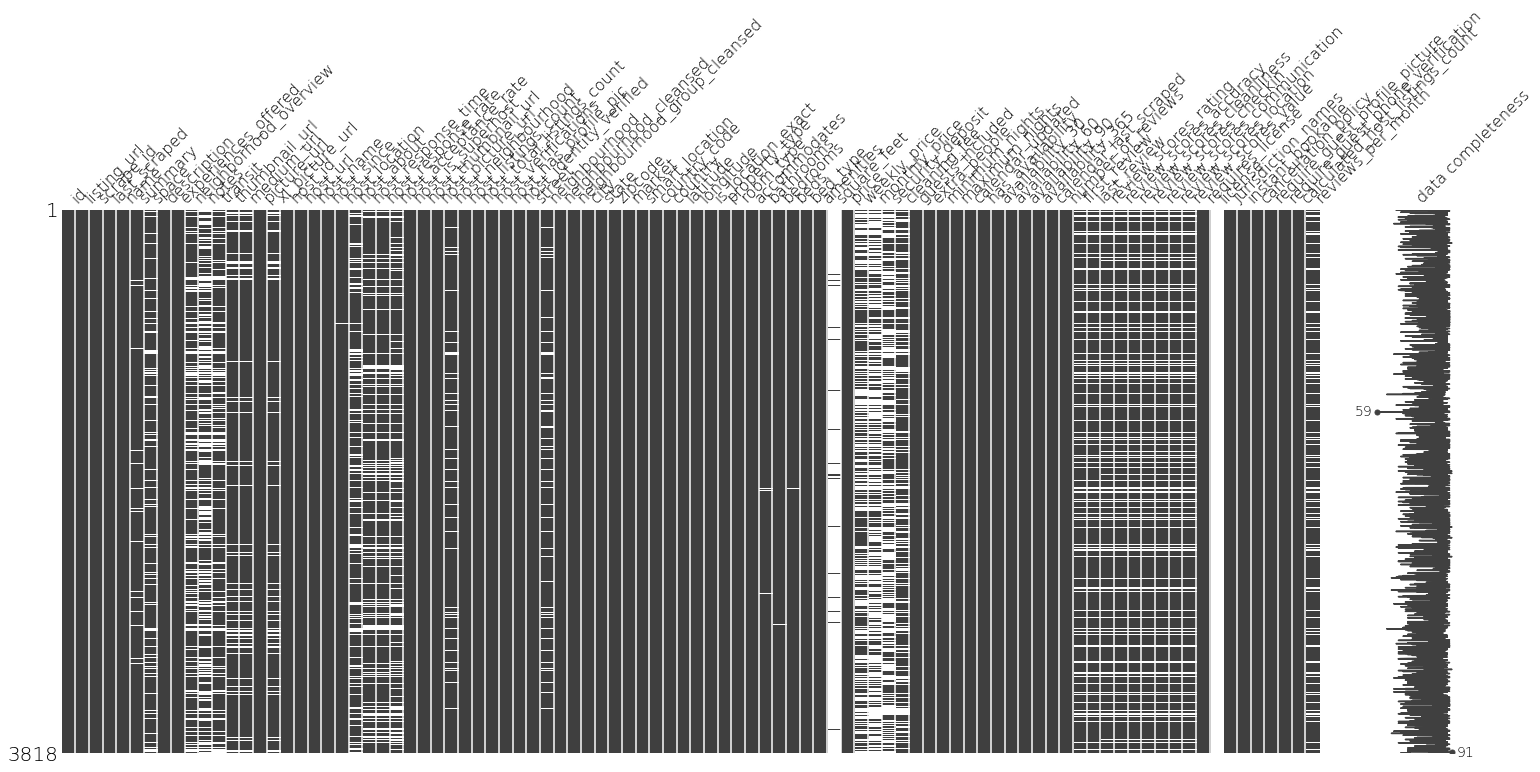

In [19]:
missingno.matrix(listings, labels=True);

This data describes each of the listings on AirBnB. There are a total of 91 columns and a lot of them have missing values at various places. 

The row with the minium missing values still has 59 values missing, and the row with the maximum values missing has 91 values missing. 

There are good reasons for listing data to have missing values since listings are of various types, also the owner might not have completed the many ways in which there is to describe the listing.

In [20]:
print(f'Number of rows in listings: {len(listings)}')

Number of rows in listings: 3818


### Cleaning

In [21]:
def clean_listings(listings):
    listings_clean = listings.copy()

    # Converting percentage strings into floats
    listings_clean['host_response_rate'] = listings_clean['host_response_rate'].str.replace('%','').astype('float')
    listings_clean['host_acceptance_rate'] = listings_clean['host_acceptance_rate'].str.replace('%','').astype('float')
    
    # Converting price to a float value
    listings_clean['price'] = listings_clean['price'].str.replace('[$,]','').astype('float')
    listings_clean['weekly_price'] = listings_clean['weekly_price'].str.replace('[$,]','').astype('float')
    listings_clean['monthly_price'] = listings_clean['monthly_price'].str.replace('[$,]','').astype('float')
    listings_clean['security_deposit'] = listings_clean['security_deposit'].str.replace('[$,]','').astype('float')
    listings_clean['cleaning_fee'] = listings_clean['cleaning_fee'].str.replace('[$,]','').astype('float')
    listings_clean['extra_people'] = listings_clean['extra_people'].str.replace('[$,]','').astype('float')
    
    # Converting the date to a pandas datetime type
    listings_clean['last_scraped'] = pd.to_datetime(listings_clean['last_scraped'])
    listings_clean['host_since'] = pd.to_datetime(listings_clean['host_since'])
    listings_clean['calendar_last_scraped'] = pd.to_datetime(listings_clean['calendar_last_scraped'])
    listings_clean['first_review'] = pd.to_datetime(listings_clean['first_review'])
    listings_clean['last_review'] = pd.to_datetime(listings_clean['last_review'])
    
    return listings_clean

In [22]:
listings_clean = clean_listings(listings)

## Reviews

In [23]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


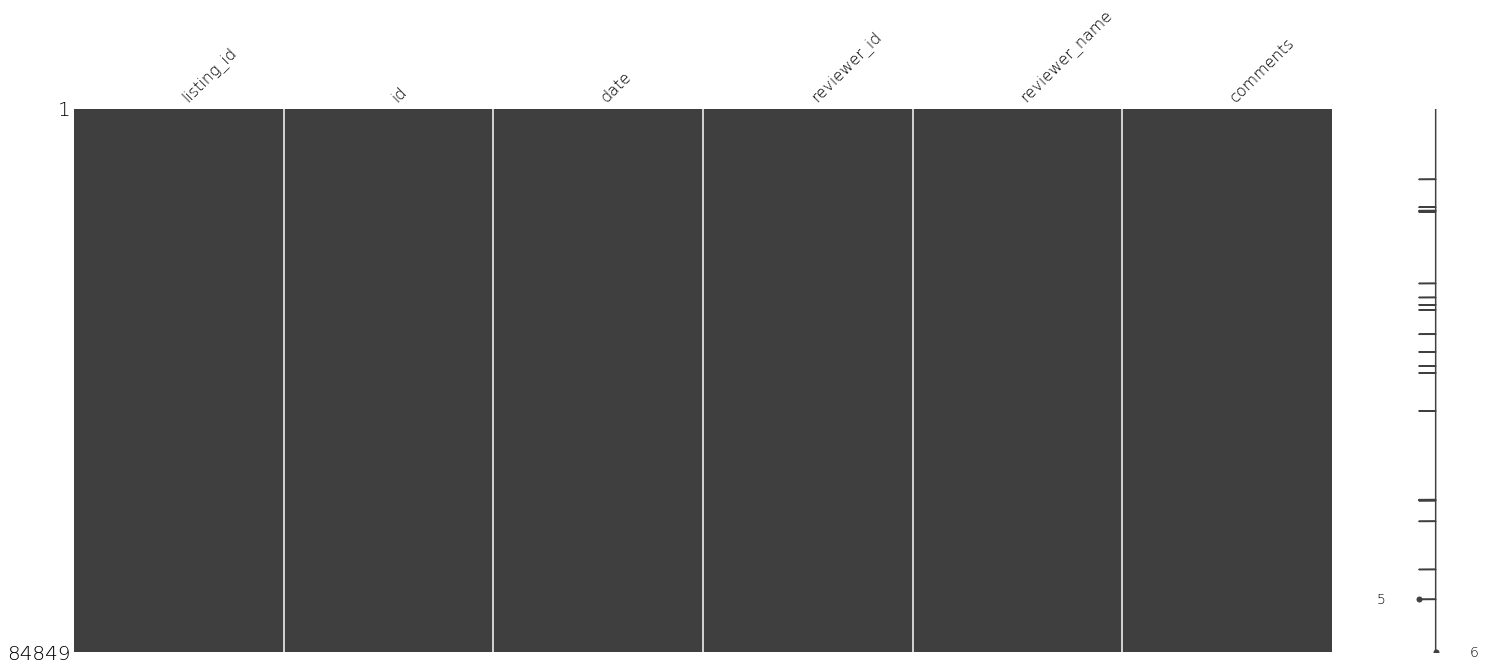

In [24]:
missingno.matrix(reviews)

This data shows the visitors reviews in text for a given listing, at a given date. Remarkably there are very few missing values.

In [25]:
print(f'Number of rows in reviews: {len(reviews)}')

Number of rows in reviews: 84849


# Business Understanding

Questions to answer with the data
- What is the yearly price trend?
- What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?
- Are there any property types that demand a higher price than others?
- How many consecutive days are properties usually rented out for?

# Q1: What is the yearly price trend

In [26]:
# We group by date and compute basic statistics
calendar_stats = (calendar_clean[calendar_clean['available'] == 't']
                  .groupby(['date'])
                  .agg({'cleaned_price':{'min','max','std','mean'}})
                 )
# Filter so that we look at a complete year
calendar_year = calendar_stats['2016-01-01':'2016-12-31']
# Resample on month basis and take the mean
calendar_month = calendar_stats.resample('M').mean()
# Get nice names for the months
calendar_month['month_names'] = calendar_month.index.strftime('%b')

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


Mean price: $137.66


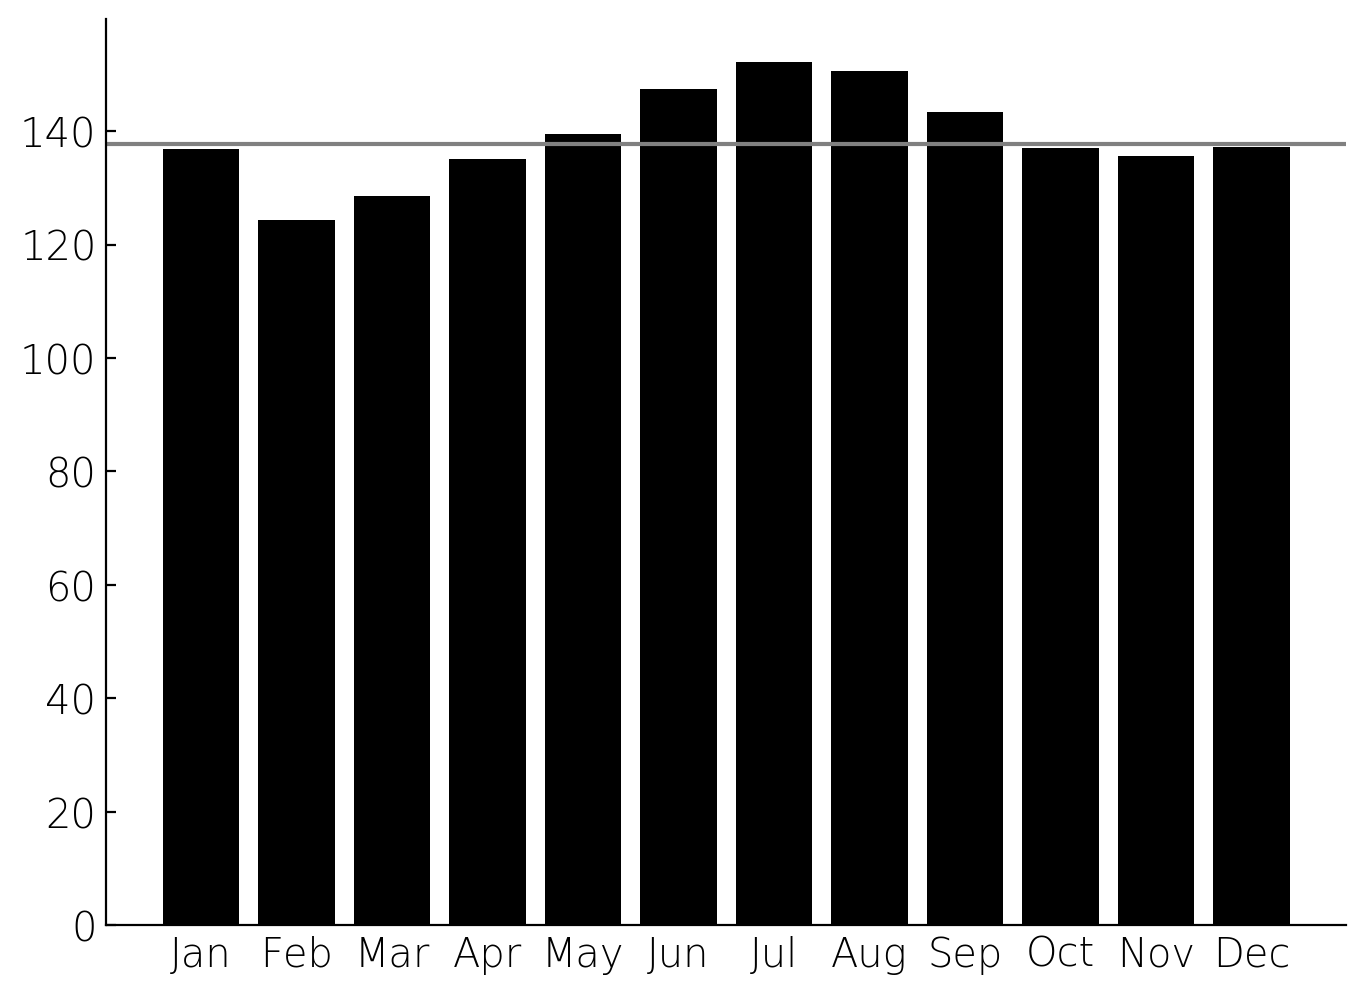

In [27]:
# Use matplotib to display barchart over mean prices per month
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
ax.bar(calendar_month['month_names'], calendar_month['cleaned_price']['mean'], color='k')
price_mean = calendar_month['cleaned_price']['mean'].mean()
ax.axhline(calendar_month['cleaned_price']['mean'].mean(), c='gray')
print(f'Mean price: ${round(price_mean,2)}')
ax.grid(False)
ax.set_ylim(0,None)
fig.savefig('yearly_trend.png', dpi=200);

In [28]:
# Show overview per month, also showing min, max and std
calendar_month

cleaned_price                                    month_names
                     max        mean         std        min            
date                                                                   
2016-01-31    988.392857  121.692505   86.837877  21.000000         Jan
2016-02-29   1000.000000  124.315614   91.483902  20.689655         Feb
2016-03-31   1099.000000  128.640797   94.292904  20.000000         Mar
2016-04-30   1092.400000  135.109460   98.167124  20.000000         Apr
2016-05-31   1099.000000  139.539566  102.701959  20.000000         May
2016-06-30   1099.000000  147.469191  112.386836  20.000000         Jun
2016-07-31   1195.225806  152.102977  120.059787  20.000000         Jul
2016-08-31   1218.741935  150.657032  118.737648  20.000000         Aug
2016-09-30   1430.000000  143.277182  108.727341  20.000000         Sep
2016-10-31   1643.548387  137.033871  104.442009  20.000000         Oct
2016-11-30   1650.000000  135.687825  104.219171  19.666667         Nov
2016-12-31   1650.000000  137.238611  105.002975  20.000000         Dec
2017-01-31   1000.000000  136.849867  104.647242  20.000000         Jan

From above the average price doesn't vary much over the year.

# Q2: What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?

In [29]:
# Merge calendar data that contain prices with listing data filtered down to neighborhood
neighbourhood_price = listings_clean[['id', 'neighbourhood_cleansed']].merge(calendar_clean, left_on='id', right_on='listing_id')

In [30]:
# Pivot so we get neighbourhood versus price
neighbourhood_pivot = neighbourhood_price.pivot(columns='neighbourhood_cleansed', values='cleaned_price')
neighbourhood_sort_index = neighbourhood_pivot.mean().sort_values(ascending=False).index

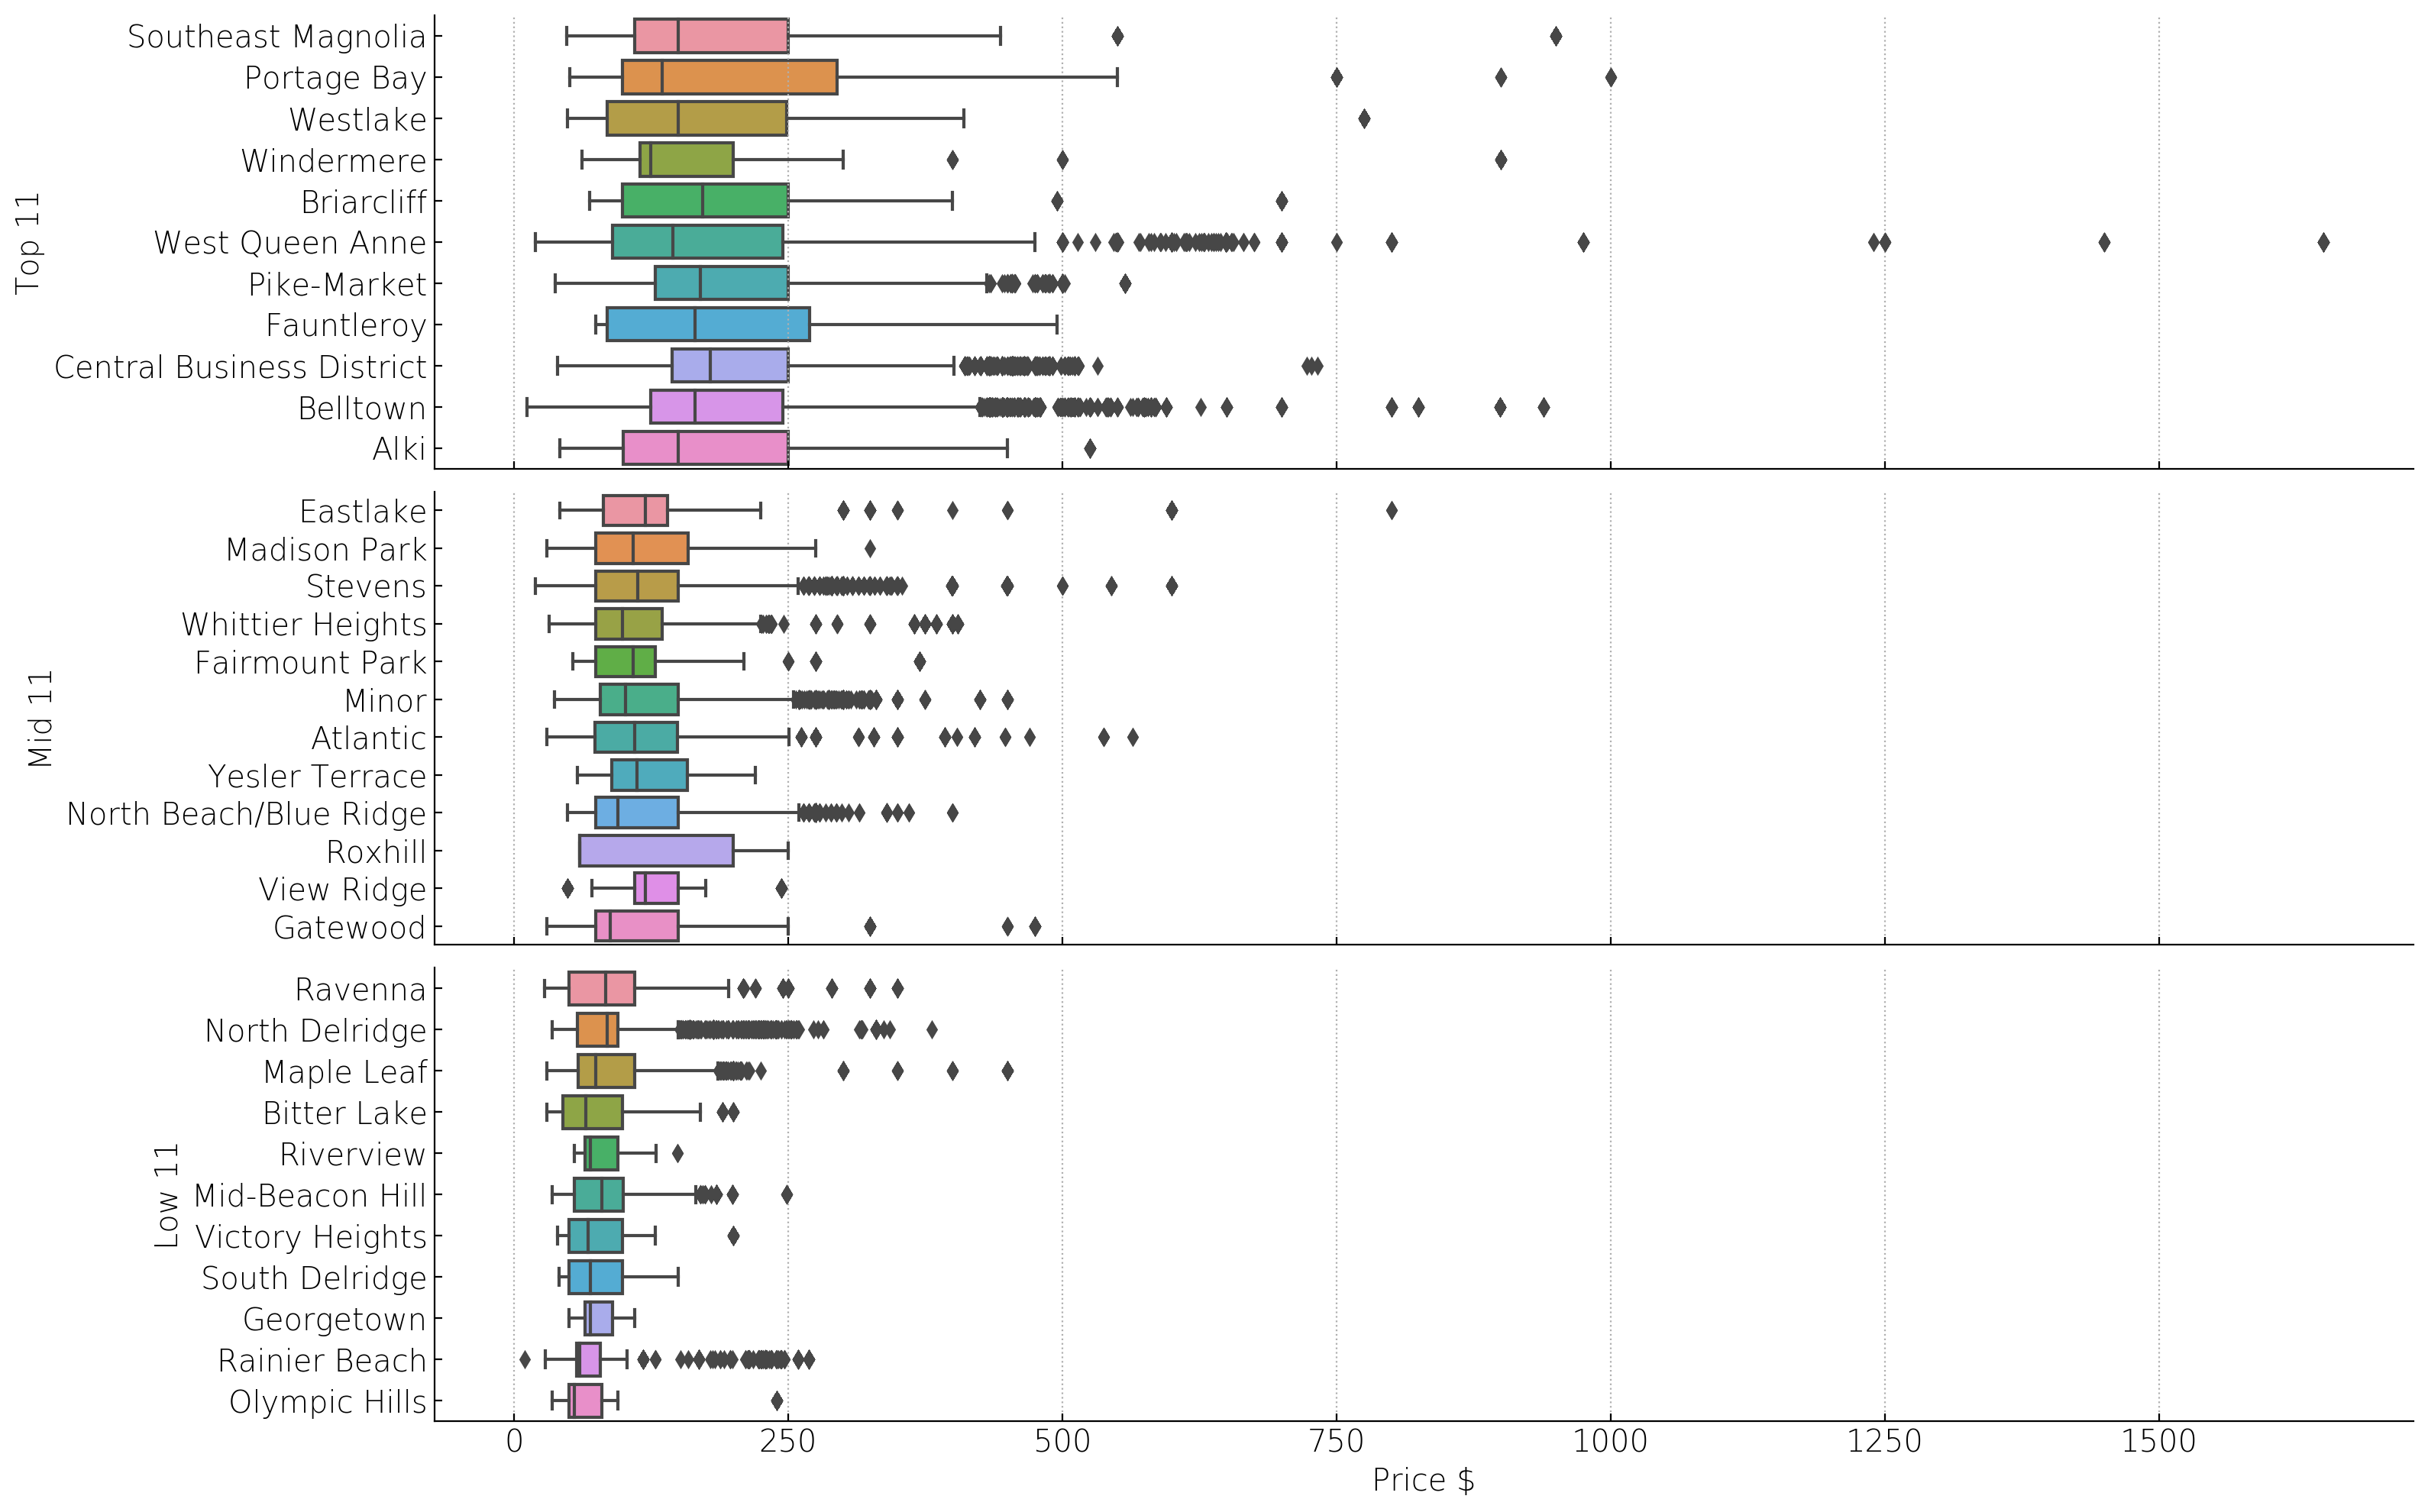

In [31]:
# Plot top, mid and bottom neighbourhoods when it comes to price
fig,ax = plt.subplots(3,1, figsize=(16,10), sharex=True, dpi=200)

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[:11]], orient='h', ax=ax[0])
ax[0].set_ylabel('Top 11')

midpoint = len(neighbourhood_sort_index)/2
sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[round(midpoint-5):round(midpoint+6)]], orient='h', ax=ax[1])
ax[1].set_ylabel('Mid 11')

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[-11:]], orient='h', ax=ax[2])
ax[2].set_ylabel('Low 11')
ax[2].set_xlabel('Price $')

fig.set_tight_layout(True)
fig.savefig('neighborhood_comparison.png', dpi=200);

# Q3: Property types vs price

In [32]:
# Merge calendar data with prices with listings data filtered down to property type
room_type_price = listings_clean[['id', 'property_type']].merge(calendar_clean, left_on='id', right_on='listing_id')
# Pivot so we have property type versus price
room_type_price_pivot = room_type_price.pivot(columns='property_type', values='cleaned_price')

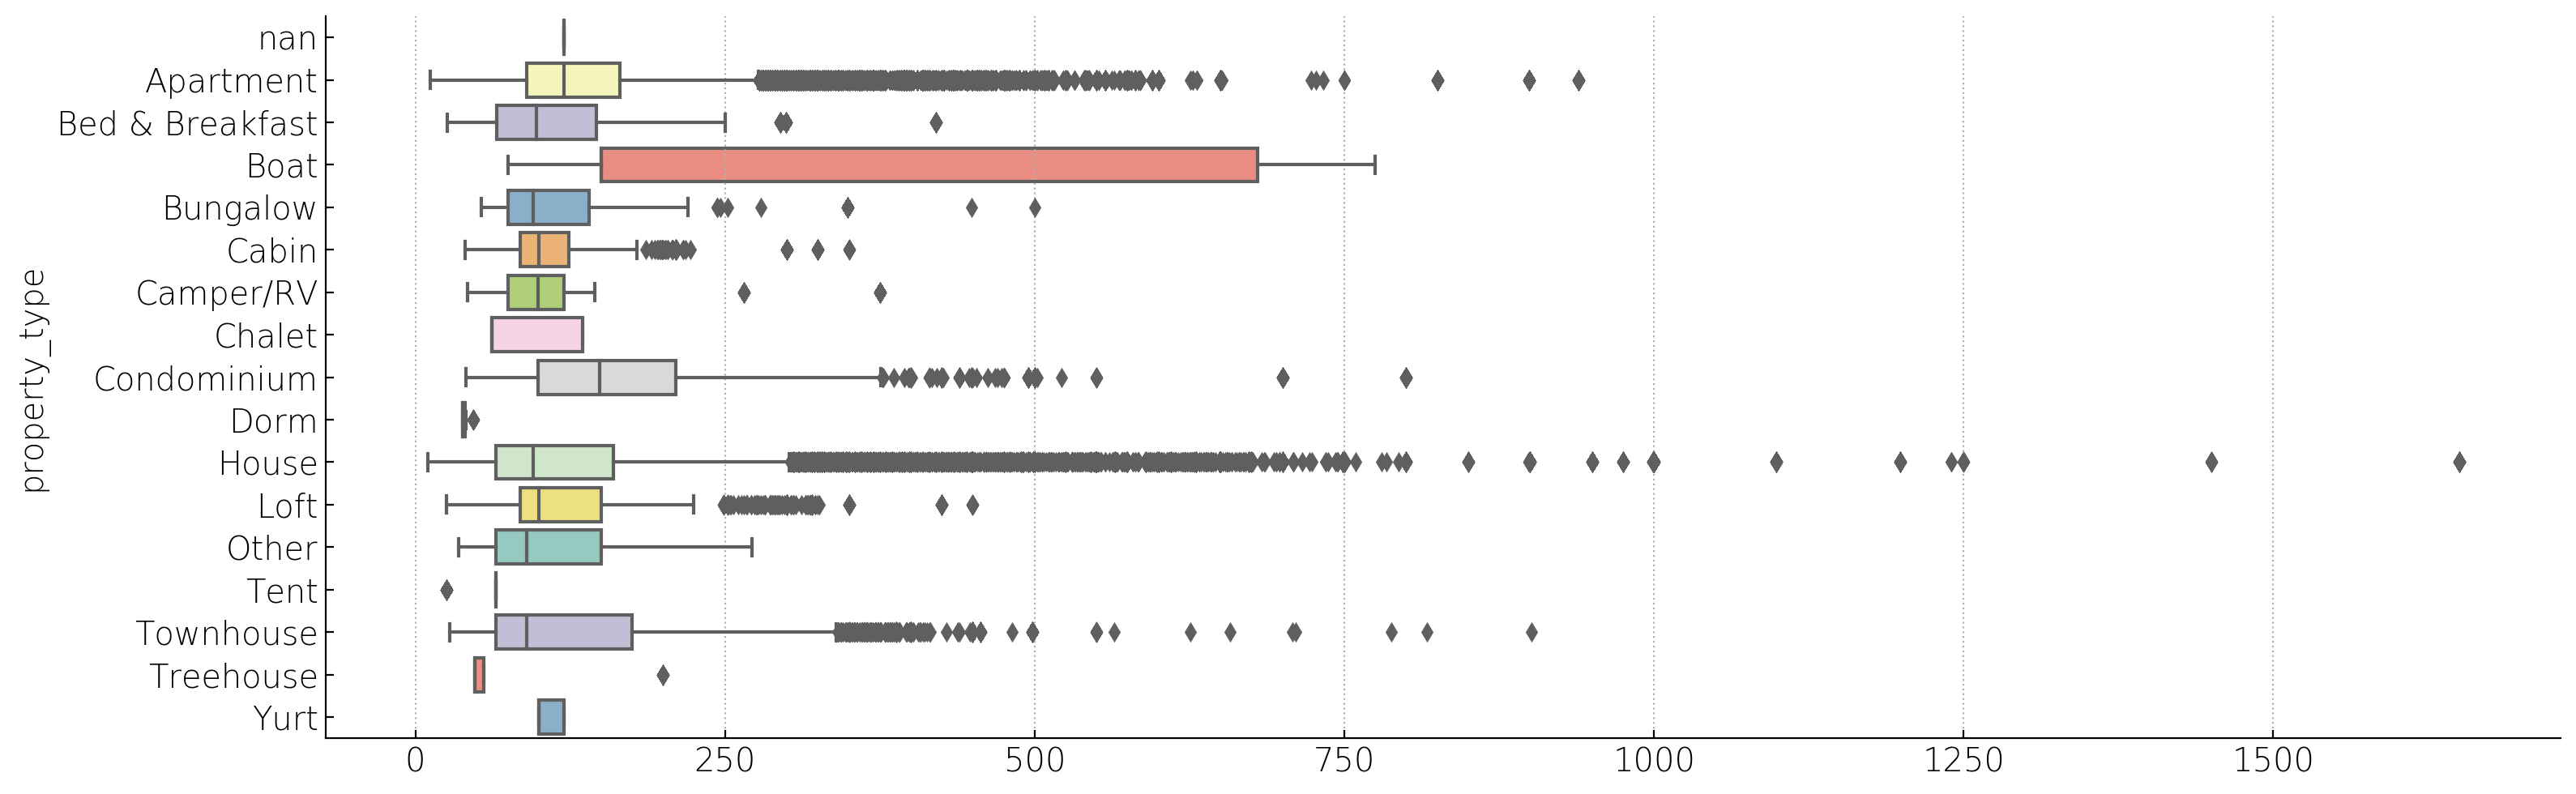

In [33]:
# Plot property type versus price
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.boxplot(data=room_type_price_pivot, orient='h', ax=ax, palette='Set3')
fig.set_tight_layout(True)
fig.savefig('property_type.png', dpi=200);

## Q4: Yearly availability trend

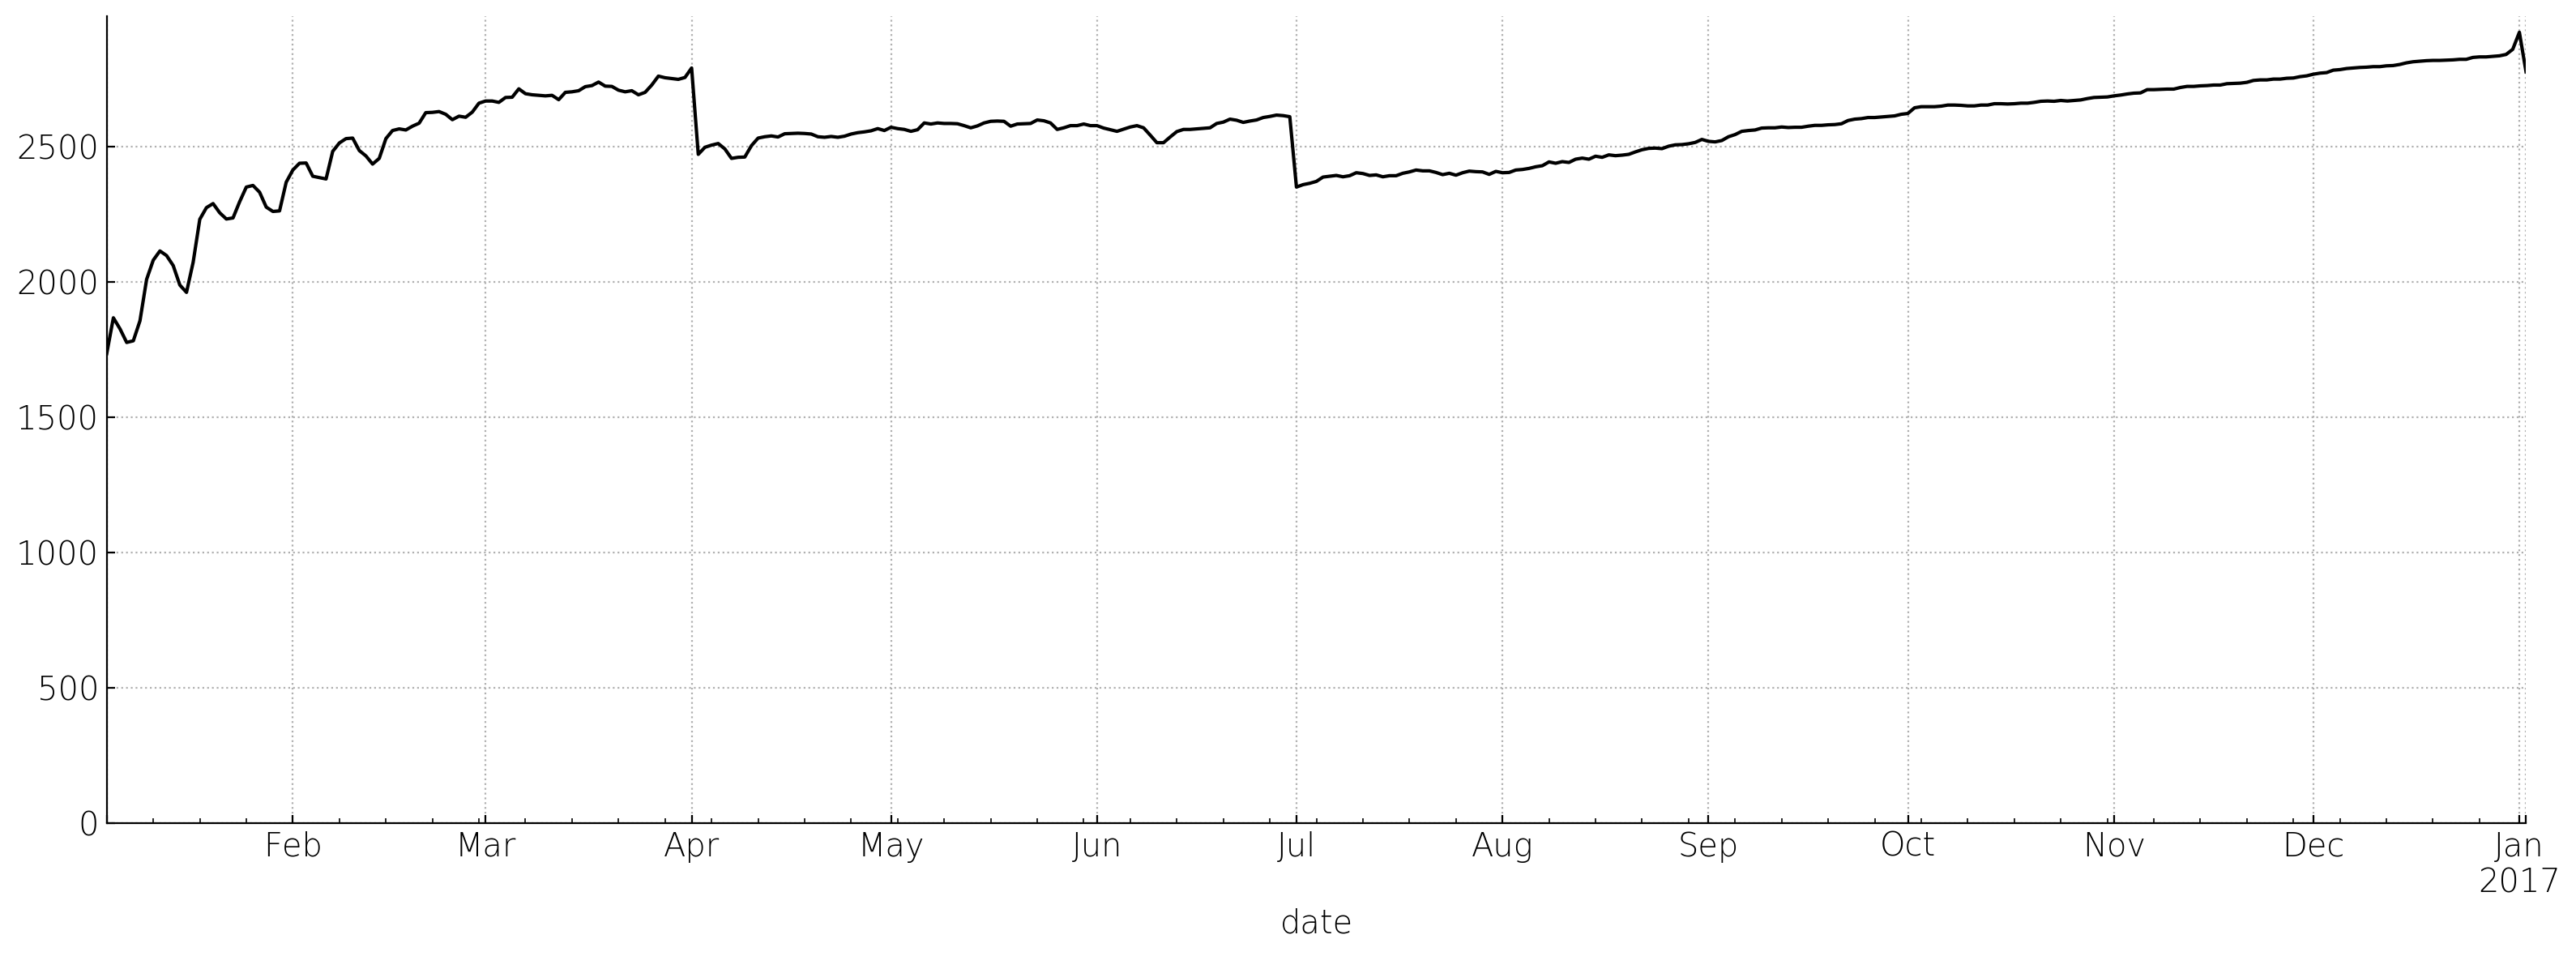

In [34]:
# Plot yearly availability
fig,ax = plt.subplots(figsize=(16,6), dpi=200)
calendar_clean[calendar_clean['available'] == 't'].groupby('date').size().plot(ax=ax, c='k')
ax.set_ylim(0,None)
fig.set_tight_layout(True)
fig.savefig('yearly_availability_trend.png', dpi=200);

The plot above shows the number of available listings for any given day of the year. Either there are some issues with the data or there are some very consistent trends. The sharp jumps at April and July signify that a lot of listings were either reserved or taken offline. 

## Q5: Consecutive rental days

In [35]:
# Calculate consecutive rentals, pivot calendar table for each listing versus date, using available as value
calendar_pivot = calendar_clean.pivot(index='date', columns='listing_id', values='available')

consec_days = []
# Iterate through each listing in the columns
for col in calendar_pivot.columns:
    dat = calendar_pivot[col].reset_index()
    # Check each column for change in state, count each change in state as a new grouping
    dat['grp'] = (dat[col] != dat[col].shift(1)).cumsum()
    # Group by change in state and get amount of days in each state
    dat = dat.groupby([col,'grp']).size().reset_index(name='consecutive_days')
    # Make nicer columns for output
    dat.columns = ['availability', 'group', 'consecutive_days']
    dat['listing_id'] = col
    consec_days.append(dat)

# Concatenate all the individual listing consecutive rental day data into one dataframe
consecutive_rental_days_listing = pd.concat(consec_days, axis=0)

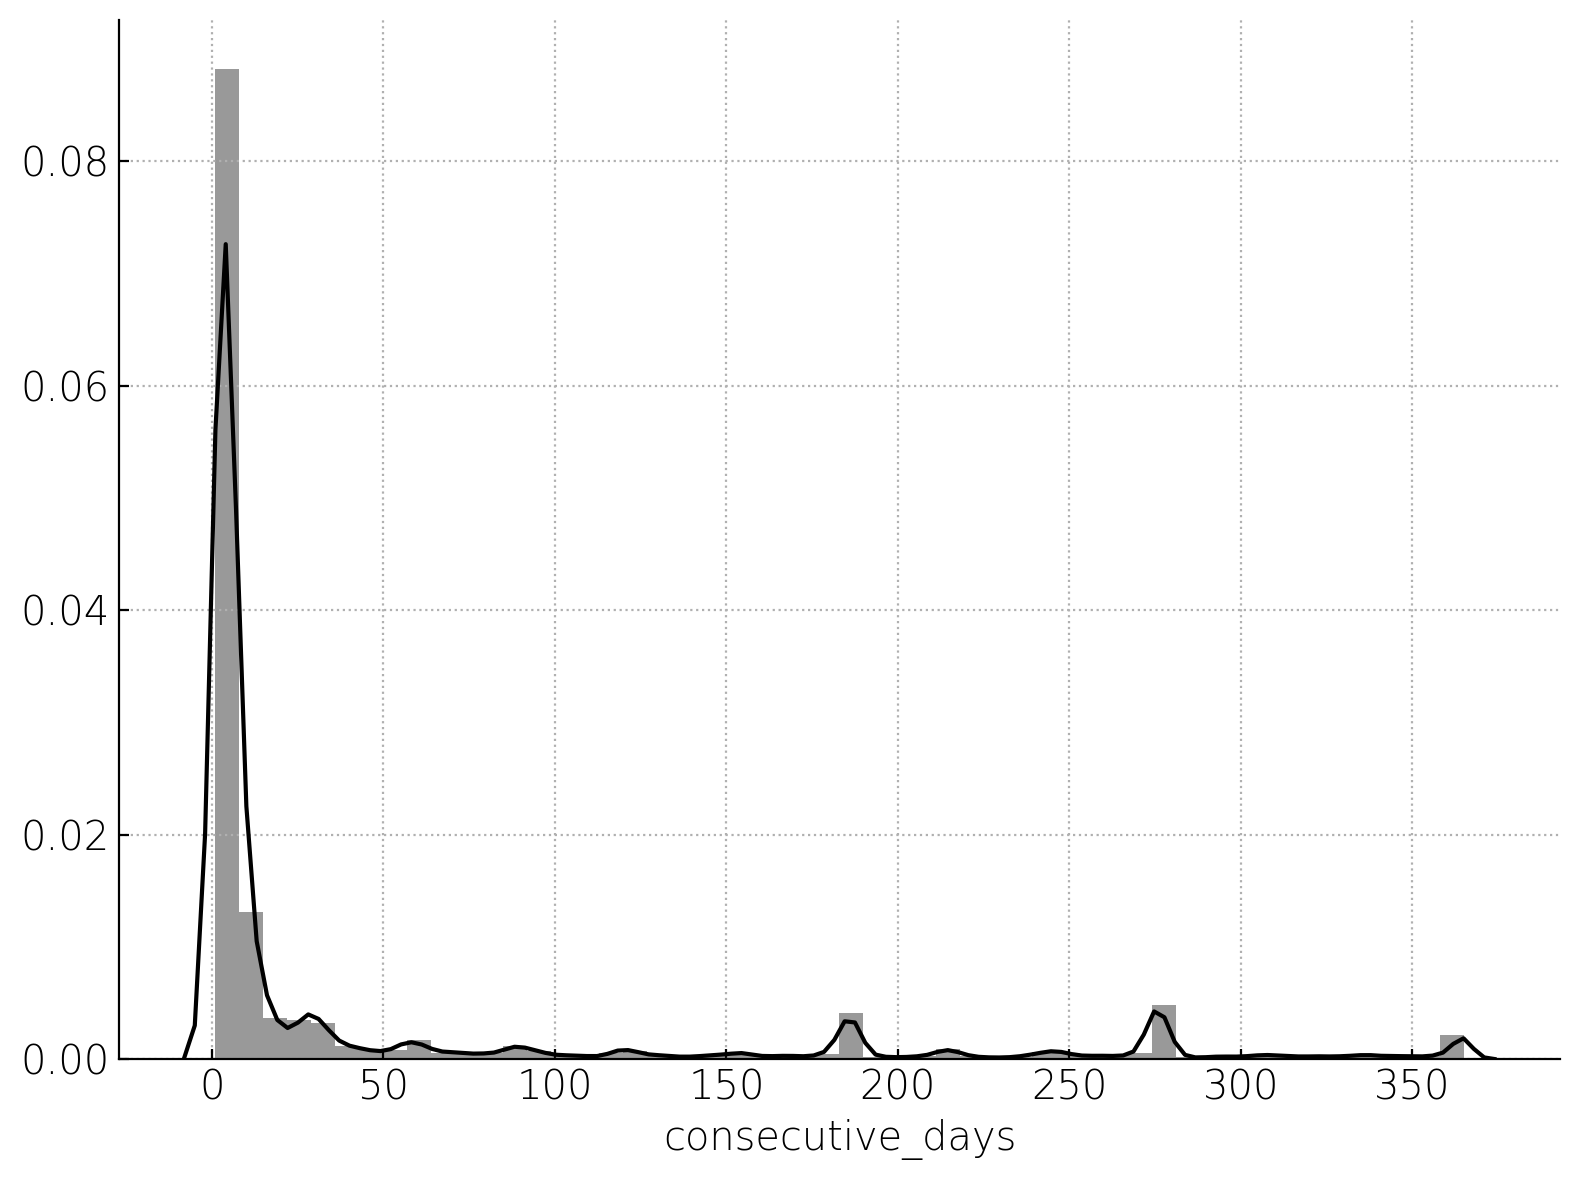

In [36]:
# Plot consecutive rental day data
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
consecutive_rented_days = consecutive_rental_days_listing[consecutive_rental_days_listing['availability'] == 'f']['consecutive_days']
sns.distplot(consecutive_rented_days, bins=52, color='k')
ax.set_yscale('linear')
fig.set_tight_layout(True)
fig.savefig('consecutive.png', dpi=200);

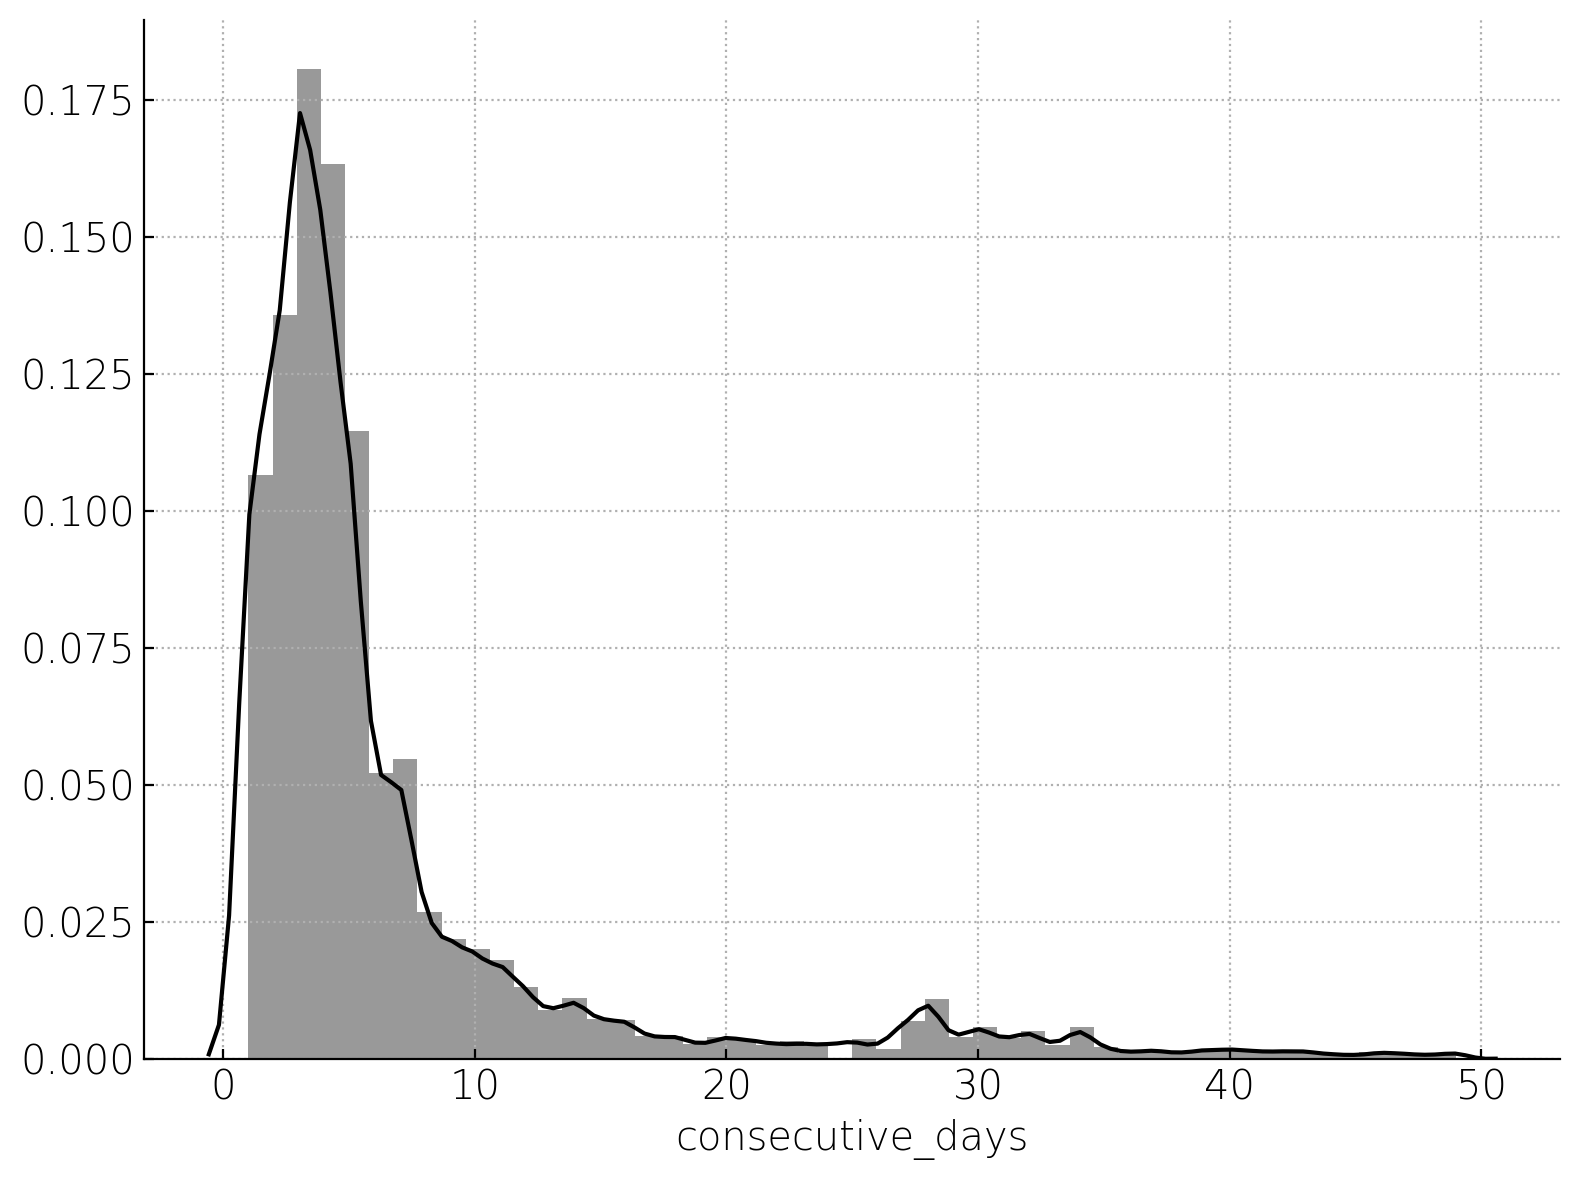

In [37]:
# Zoom in on the first part of the plot, to reveal more detail about regular rental behavior
fig,ax = plt.subplots(figsize=(8,6), dpi=200)
consecutive_rented_days = consecutive_rental_days_listing[consecutive_rental_days_listing['availability'] == 'f']['consecutive_days']
sns.distplot(consecutive_rented_days[consecutive_rented_days < 50], bins=50, color='k')
ax.set_yscale('linear')
fig.set_tight_layout(True)
fig.savefig('consecutive_small.png', dpi=200);

- Caveat, might not be distinct customers (neck to neck bookings)
- Might not show longer than a year bookings also, since we only look at data for a year (not so critical)


## Are there any property types that show a norm of amount of consecutive rented days

In [38]:
# Join the consecutive rental data with property type from listing data
property_vs_rental = (consecutive_rental_days_listing[consecutive_rental_days_listing['availability'] == 'f']
                      .merge(listings_clean[['id','property_type']], left_on='listing_id', right_on='id')
                     )

In [39]:
# Pivot so we have property type versus number of consecutive rental days
property_vs_rental_piv = property_vs_rental.pivot(columns='property_type', values='consecutive_days')

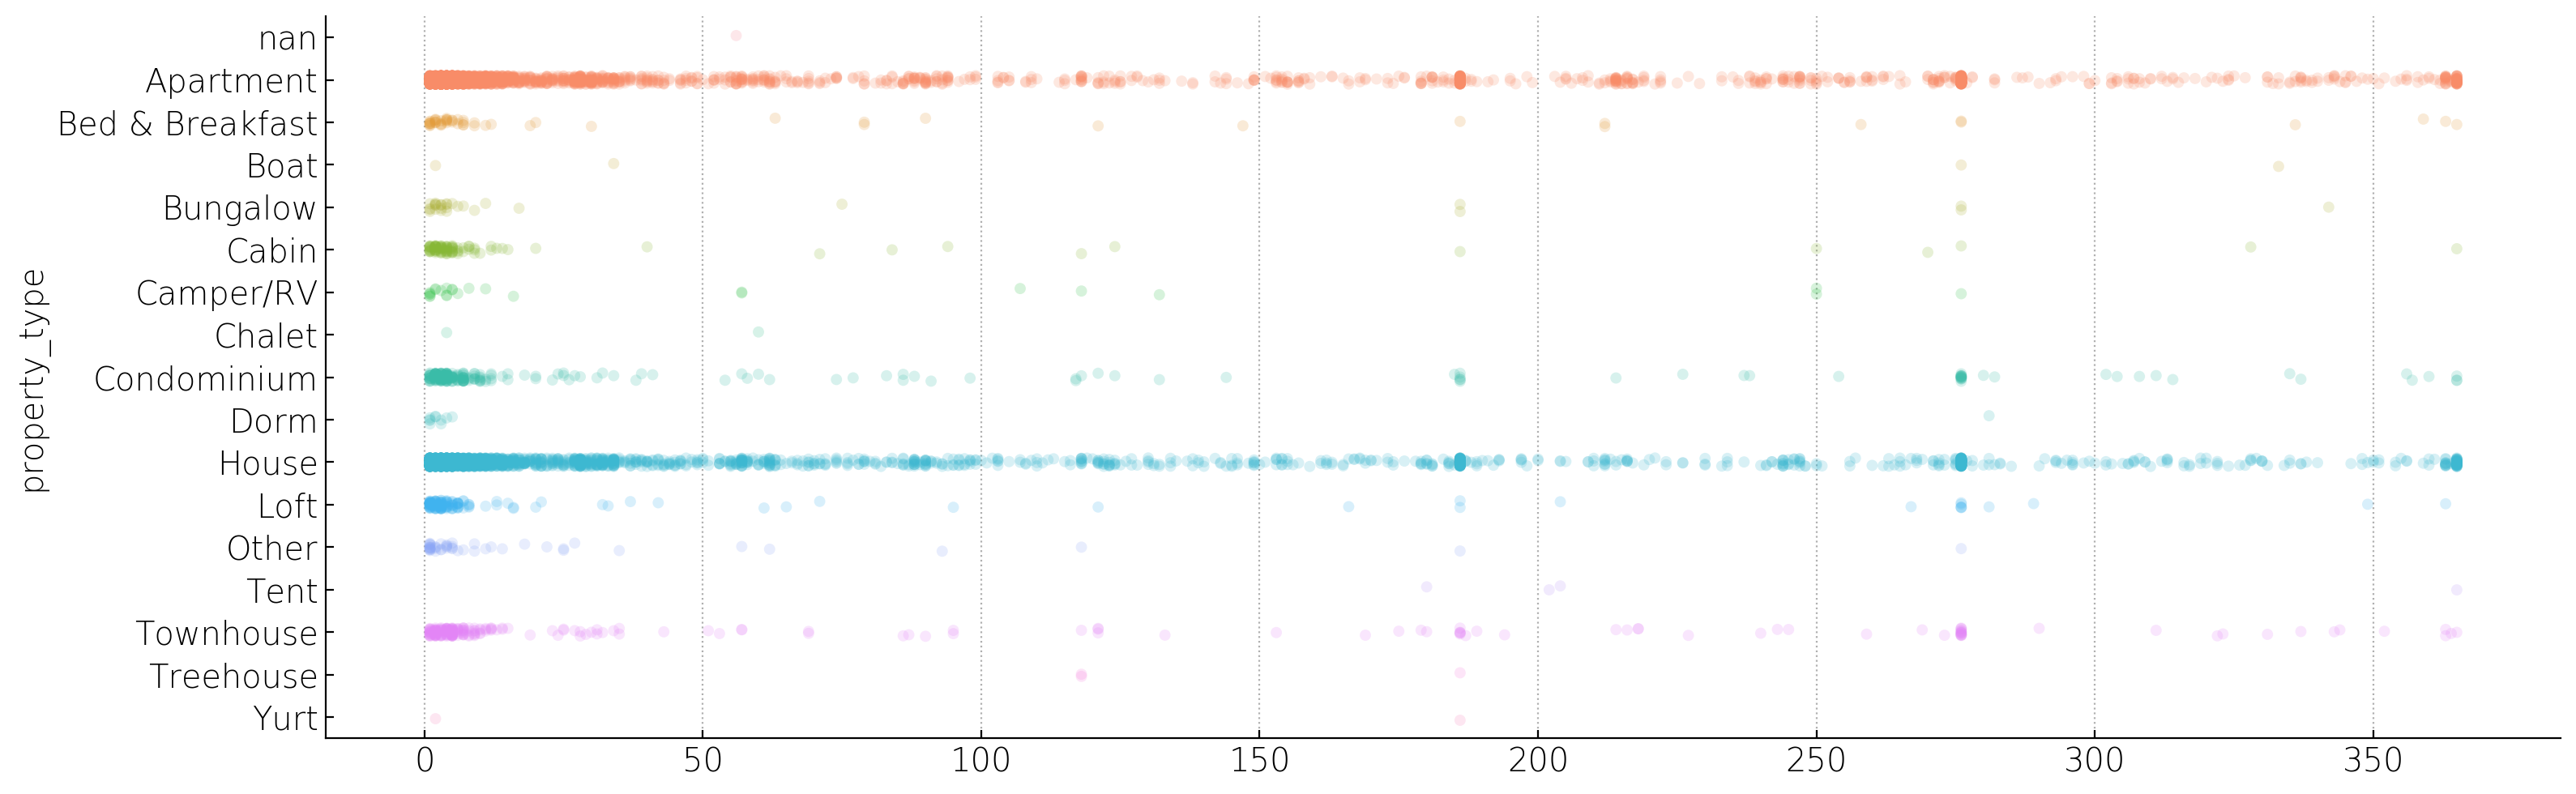

In [40]:
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.stripplot(data=property_vs_rental_piv, orient='h', ax=ax, alpha=.2)
fig.set_tight_layout(True)
fig.savefig('rental_days_dist.png', dpi=200);

# What features have inpact on price?

In this section I will use XGBoost regressor to model the listing prices versus features present in the listings data. This will to a certain degree allow me to understand what affects the price of a listing, given that it is possible to firstly model the data to a high enough degree, secondly that it is possible to explain the resulting model.

## Feature generation

In [41]:
# We want a response variable that always has labels, as opposed to the above analysis
calendar_clean = calendar_clean[calendar_clean['available'] == 't']
# Joining the listings and calendar dataset, and dropping price columns from listings in order not to collide with calendar price column
X = listings_clean.drop('price', axis=1).merge(calendar_clean, left_on='id', right_on='listing_id')

In [42]:
# Definition of selected columns and their types
continuous = [
    'host_response_rate',
    'host_acceptance_rate',
    'host_listings_count',
    'host_total_listings_count',
    #'zipcode',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'guests_included',
    'extra_people',
    'minimum_nights',
    'maximum_nights',
    'square_feet',
    'cleaning_fee',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'reviews_per_month'
]
dates = [
    'host_since',
    'first_review',
    'last_review'
]
categorical = [
    'host_response_time',
    'host_location',
    'host_is_superhost',
    'host_neighbourhood',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'city',
    'state',
    'market',
    'smart_location',
    'country_code',
    'country',
    'property_type',
    'room_type',
    'bed_type'
]
# Response variable that we would like to predict
response = [
    'cleaned_price'
]

In [43]:
# Using pandas' get dummies to one-hot-encode the categorical features. This must be done before splitting,
# to ensure we get all possible columns in both datasets.
X_dummies = pd.get_dummies(X[continuous+categorical])

In [45]:
# We use sklearn to split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies, X[response], test_size=.25)

In [46]:
# In order to iterate faster, it is good to save the dataset to disk, 
# this avoids having to re-process the data every time the kernel is restarted.
X_train.to_pickle(DATA_FOLDER / 'X_train.pkl')
X_test.to_pickle(DATA_FOLDER / 'X_test.pkl')
y_train.to_pickle(DATA_FOLDER / 'y_train.pkl')
y_test.to_pickle(DATA_FOLDER / 'y_test.pkl')

## Modelling

In [7]:
# Load train and test data from disk
X_train = pd.read_pickle(DATA_FOLDER / 'X_train.pkl')
X_test = pd.read_pickle(DATA_FOLDER / 'X_test.pkl')
y_train = pd.read_pickle(DATA_FOLDER / 'y_train.pkl')
y_test = pd.read_pickle(DATA_FOLDER / 'y_test.pkl')

In [8]:
# Use the sklearn interface to XGBoost, using the regressor
reg = xgb.XGBRegressor(max_depth=10, eta=1)

In [9]:
# We start the training of the model, and set early stopping to 5 rounds. The eval set is set to the testing set
# this allows the algorithm to stop early given that it does not improve for 5 iterations.
model = reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5, verbose=True)

[0]	validation_0-rmse:42.59105
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:39.63045
[2]	validation_0-rmse:38.07384
[3]	validation_0-rmse:36.64004
[4]	validation_0-rmse:34.74975
[5]	validation_0-rmse:34.45723
[6]	validation_0-rmse:33.48292
[7]	validation_0-rmse:33.22690
[8]	validation_0-rmse:32.85646
[9]	validation_0-rmse:32.32014
[10]	validation_0-rmse:32.16128
[11]	validation_0-rmse:32.08992
[12]	validation_0-rmse:31.88004
[13]	validation_0-rmse:31.12809
[14]	validation_0-rmse:30.88455
[15]	validation_0-rmse:30.53384
[16]	validation_0-rmse:30.27208
[17]	validation_0-rmse:29.94056
[18]	validation_0-rmse:29.81503
[19]	validation_0-rmse:29.62955
[20]	validation_0-rmse:29.35106
[21]	validation_0-rmse:29.15504
[22]	validation_0-rmse:29.02342
[23]	validation_0-rmse:28.89570
[24]	validation_0-rmse:28.73834
[25]	validation_0-rmse:28.71536
[26]	validation_0-rmse:28.65188
[27]	validation_0-rmse:28.60030
[28]	validation_0-rmse:28.56047
[29]	validation_0-

## Model evaluation

In [10]:
# Run the model on the training and test data
y_train['prediction'] = reg.predict(X_train)
y_test['prediction'] = reg.predict(X_test)

In [11]:
# We evaluate the model by first looking at the difference in prediction and actual price,
# between the training and test data.
y_train['diff'] = y_train['cleaned_price'] - y_train['prediction']
y_test['diff'] = y_test['cleaned_price'] - y_test['prediction']

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


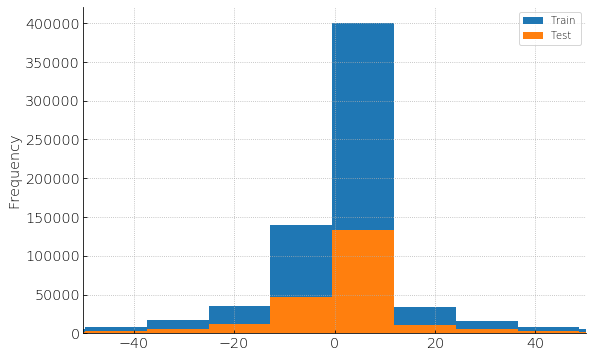

In [12]:
fig,ax = plt.subplots(figsize=(9,6))
y_train['diff'].plot.hist(ax=ax, label='Train', bins=150)
y_test['diff'].plot.hist(ax=ax, label='Test', bins=150)
ax.legend()
ax.set_xlim(-50,50);

Looking at the graph we get a fairly similar behavior between the training and test data.

In [13]:
# Calculate r-squared and root-mean-squared-error to evaluate training and testing performance
train_r2 = r2_score(y_train['cleaned_price'], y_train['prediction'])
test_r2 = r2_score(y_test['cleaned_price'], y_test['prediction'])
print(f'Train r2: {train_r2}')
print(f'Test r2: {test_r2}')

train_rmse = sqrt(mean_squared_error(y_train['cleaned_price'], y_train['prediction']))
test_rmse = sqrt(mean_squared_error(y_test['cleaned_price'], y_test['prediction']))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train r2: 0.9284139222195535
Test r2: 0.9290157526091117
Train RMSE: 28.07435019541735
Test RMSE: 28.0984502426023


## Model explanation

In this section I use SHAP values to explain how the model makes decisions on how price is set according to the given features in the listing description.

In [15]:
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig('shap_expl.png', dpi=200);